# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

import cv2

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path
import os
caffe_root = '/home/ubuntu/Amin-SSD/caffe/' #os.environ['CAFFE_ROOT']
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

* Load LabelMap.

In [3]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load Okutama labels
labelmap_file = 'data/okutama/labelmap_SDD_detection.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [4]:
model_def = 'models/VGGNet/okutama/SSD_512x512/deploy.prototxt'
model_weights = 'models/VGGNet/okutama/SSD_512x512/VGG_okutama_SSD_512x512_iter_2000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

In [5]:
# set net to batch size of 1
image_resize = 512
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image('/home/ubuntu/okutama17/1.2.10/images/100.jpg')

* Run the net and examine the top_k results

In [6]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
net.forward()
detections = net.blobs['detection_out'].data

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than .
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

* Plot the boxes

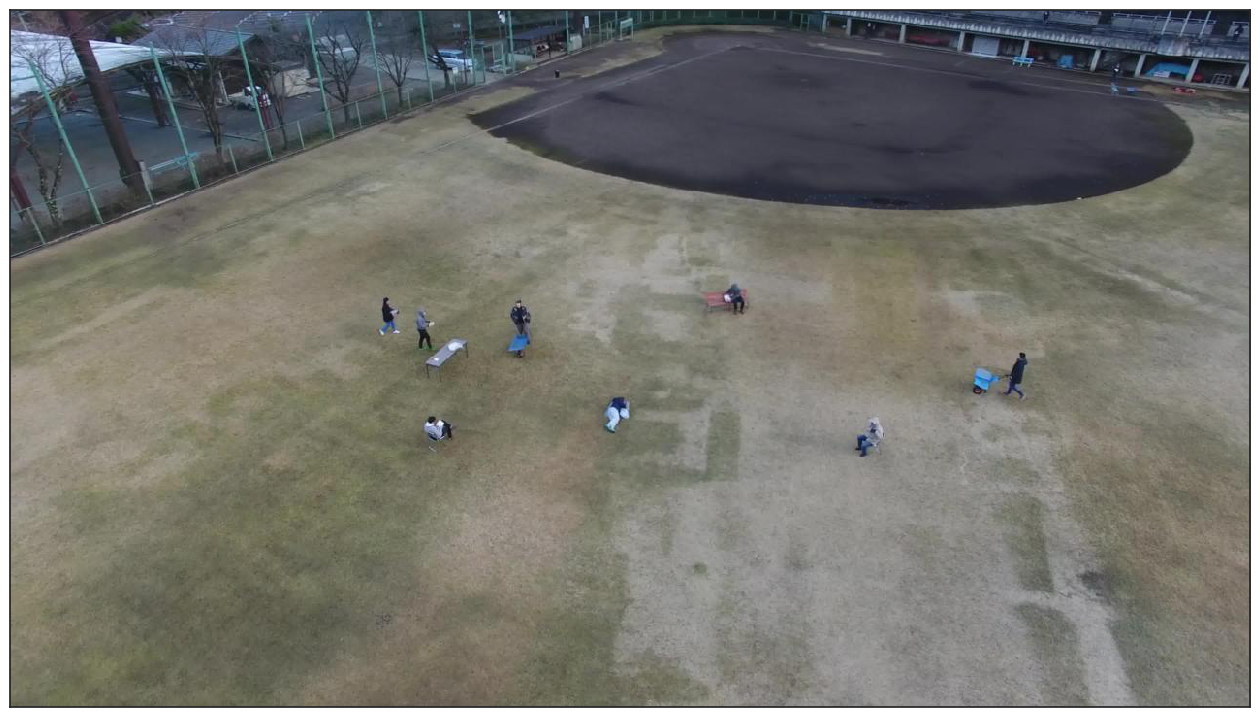

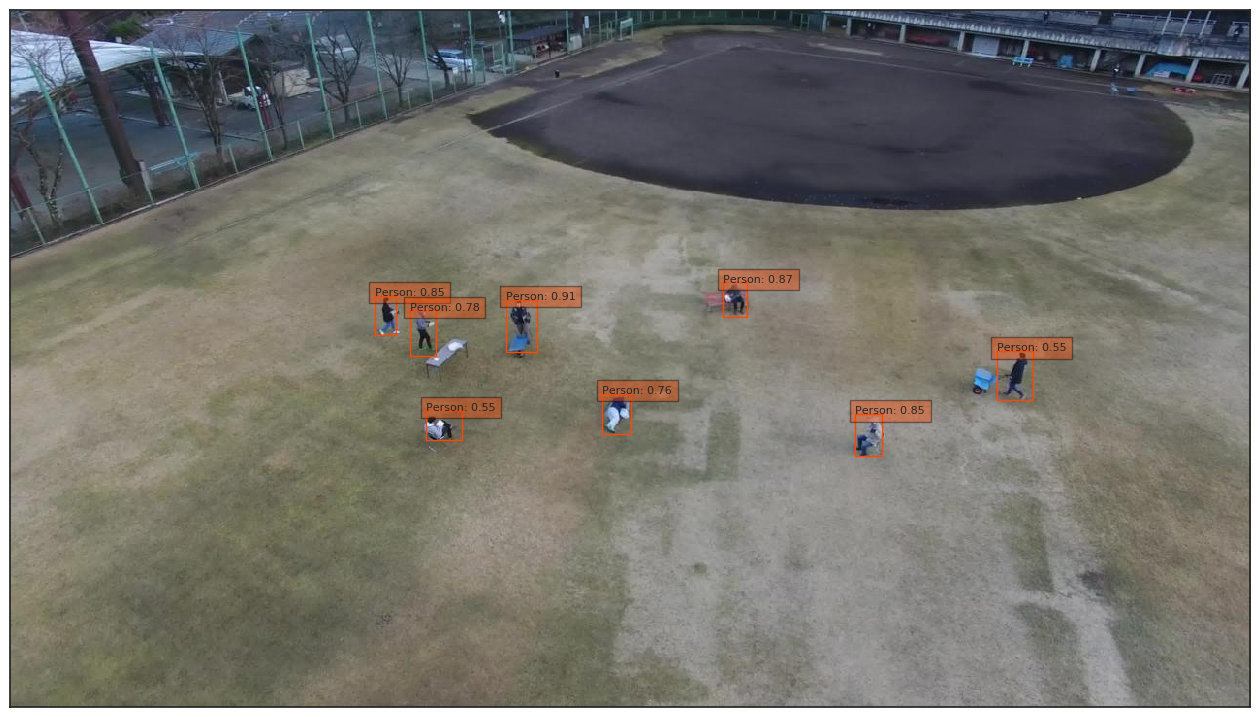

In [12]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

my_dpi = 80
plt.figure(figsize=(1280/my_dpi, 720/my_dpi), dpi=my_dpi)

fig = plt.imshow(image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)  
plt.show()

my_dpi = 80
plt.figure(figsize=(1280/my_dpi, 720/my_dpi), dpi=my_dpi)

fig = plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=1))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.4},fontsize=8)
    
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.savefig('../../output/save.jpg', bbox_inches='tight')

In [25]:
import cv2
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
img = cv2.imread('/home/ubuntu/okutama17/1.2.10/images/100.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    
    cv2.rectangle(img,(xmin,ymin),(xmax, ymax), color, 1)
    cv2.putText(img, display_txt, (xmin,ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1)
cv2.imwrite('../../output/test2.png', img)

True

### 3. SSD video

- Load frames to process

In [ ]:
# set net to batch size of 1
image_resize = 512 # Should be set
video_id = "1.2.10" # Should be set
data_set_path = "/home/ubuntu/okutama17/" # Should be Set

save_path = '../../output/'+video_id+"/"
#os.makedirs(save_path)
start_frame=0
end_frame= 1834 #len(os.listdir(video_path))
#interval=1 # should be set
threshold = 0.4  # should be set
my_dpi = 80

video_path = os.path.join(data_set_path, video_id, "images")
net.blobs['data'].reshape(1,3,image_resize,image_resize)
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()


pt=plt.figure(figsize=(1280/my_dpi, 720/my_dpi), dpi=my_dpi)

for frame in xrange(start_frame, end_frame+1):
    if frame % 50 == 0:
        print "Loading ...", frame
    image = caffe.io.load_image(os.path.join(video_path,str(frame)+'.jpg'))
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    net.forward()
    detections = net.blobs['detection_out'].data
    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]
    # Get detections with confidence higher than 
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= threshold]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    pt.clear()
    currentAxis = pt.gca()
    fig  = currentAxis.imshow(image)
    

    

    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=1))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.4},fontsize=8)

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    pt.savefig(save_path+str(frame).zfill(4)+'.jpg', bbox_inches='tight')
    
print "IT'S DONE !!!"    
    

Loading ... 0
Loading ... 50
Loading ... 100
Loading ... 150
Loading ... 200
